In [1]:
# this needs a dbto file that cannot be applied at runtime
# read overl/insert_dtbo.py
# https://discuss.pynq.io/t/pynq3-0-1-allocate-ddr4-returns-buffer-outside-of-address-range/4918/7

zero = 0x00000000
one = 0x3f800000
mone = 0xbf800000
two = 0x40000000
mtwo = 0xc0000000
three = 0x40400000
mthree = 0xc0400000
half = 0x3f000000
mhalf = 0xbf000000
third = 0x3eaaaaab
mthird = 0xbeaaaaab

# measurement settings
offset_freq = 20e3
trig_val = 500
delay_ch_2 = 0
phase_mult_ch_2 = one

In [2]:
from pynq import PL
PL.reset()

import numpy as np
import matplotlib.pyplot as plt
from pynq import allocate
import xrfdc
import time

from overlay.phase_correction_adjustable_overlay import phase_correction_adjustable_overlay
base = phase_correction_adjustable_overlay('overlay/adj.bit')
base.init_rf_clks()

base.ip_dict

{'radio/pc_averager': {'type': 'xilinx.com:hls:pc_averager:1.0',
  'mem_id': 's_axi_control',
  'memtype': 'REGISTER',
  'gpio': {},
  'interrupts': {},
  'parameters': {'C_S_AXI_CONTROL_ADDR_WIDTH': '7',
   'C_S_AXI_CONTROL_DATA_WIDTH': '32',
   'C_M_AXI_AVG_MEM_ID_WIDTH': '1',
   'C_M_AXI_AVG_MEM_ADDR_WIDTH': '64',
   'C_M_AXI_AVG_MEM_DATA_WIDTH': '512',
   'C_M_AXI_AVG_MEM_AWUSER_WIDTH': '1',
   'C_M_AXI_AVG_MEM_ARUSER_WIDTH': '1',
   'C_M_AXI_AVG_MEM_WUSER_WIDTH': '1',
   'C_M_AXI_AVG_MEM_RUSER_WIDTH': '1',
   'C_M_AXI_AVG_MEM_BUSER_WIDTH': '1',
   'C_M_AXI_AVG_MEM_USER_VALUE': '0x00000000',
   'C_M_AXI_AVG_MEM_PROT_VALUE': '"000"',
   'C_M_AXI_AVG_MEM_CACHE_VALUE': '"0011"',
   'C_M_AXI_RESULT_MEM_ID_WIDTH': '1',
   'C_M_AXI_RESULT_MEM_ADDR_WIDTH': '64',
   'C_M_AXI_RESULT_MEM_DATA_WIDTH': '512',
   'C_M_AXI_RESULT_MEM_AWUSER_WIDTH': '1',
   'C_M_AXI_RESULT_MEM_ARUSER_WIDTH': '1',
   'C_M_AXI_RESULT_MEM_WUSER_WIDTH': '1',
   'C_M_AXI_RESULT_MEM_RUSER_WIDTH': '1',
   'C_M_AXI_RESUL

averager buffer address, something wrong if not >= 0x1000000000:  0x1000000000
result address, something wrong if not >= 0x1000000000:  0x100001b000
averager buffer address, something wrong if not >= 0x1000000000:  0x1000036000
result address, something wrong if not >= 0x1000000000:  0x1000051000
buffer address, something wrong if not >= 0x1000000000:  0x100006c000
buffer address, something wrong if not >= 0x1000000000:  0x1000095000
meas no: 1 meas time avg: 5416.0  us  meas time single: 54.0  us
delay_correction:  4389


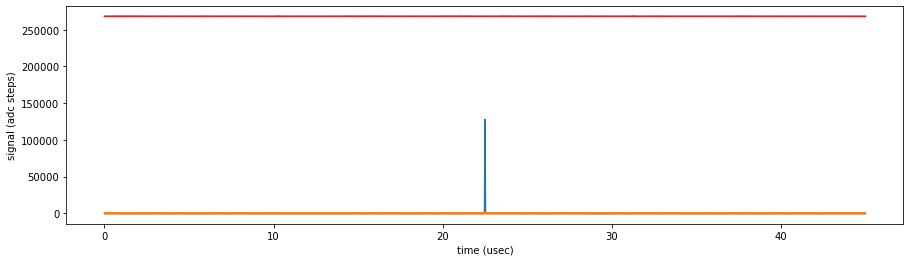

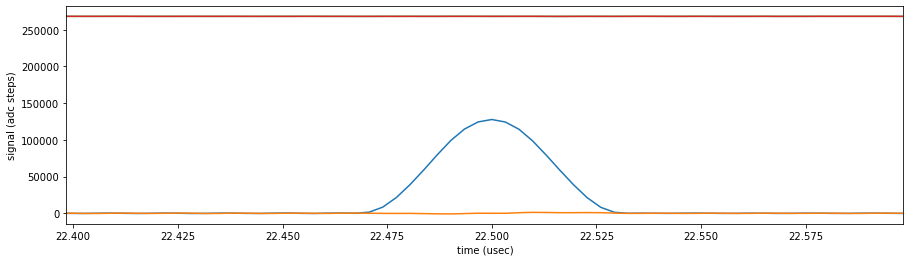

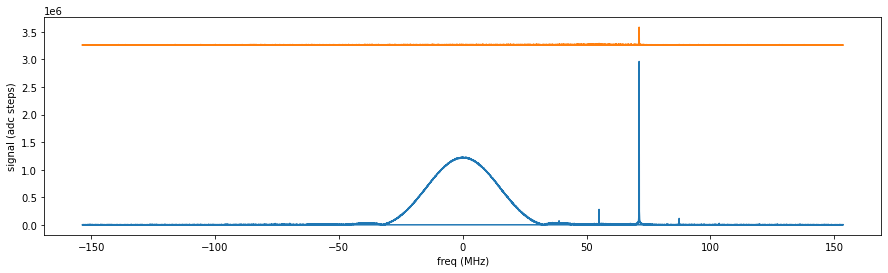

In [3]:
# this needs a dbto file that cannot be applied at runtime
# read overl/insert_dtbo.py
# https://discuss.pynq.io/t/pynq3-0-1-allocate-ddr4-returns-buffer-outside-of-address-range/4918/7
from pynq import PL
PL.reset()

import numpy as np
import matplotlib.pyplot as plt
from pynq import allocate
import xrfdc
import time

from overlay.phase_correction_adjustable_overlay import phase_correction_adjustable_overlay
base = phase_correction_adjustable_overlay('overlay/adj.bit')
base.init_rf_clks()

base.ip_dict

sampling_rate_in = 4915.2e6 / 8
sampling_rate_after_hilbert = sampling_rate_in/2
# should be a multiple of 512 (64*8)
ifg_samples = int(sampling_rate_after_hilbert/offset_freq*0.95*0.95/512.)*512
# data type is 2*int32 (real+imag)
ifg_values = int(ifg_samples*2)
data_type = np.int32

# allocates two ddr buffers (avg and final result)
avg_mem = allocate(shape=(ifg_values,), dtype=data_type, target=base.ddr.ddr4_0)
print('averager buffer address, something wrong if not >= 0x1000000000: ', hex(avg_mem.physical_address))
avg_mem[:] = np.zeros(ifg_values, dtype=data_type)
avg_mem.flush()
base.radio.pc_averager.write(base.radio.pc_averager.register_map.avg_mem_offset_1.address, int(avg_mem.physical_address & 0x00000000ffffffff))
base.radio.pc_averager.write(base.radio.pc_averager.register_map.avg_mem_offset_2.address, int(avg_mem.physical_address/2**32))

result_mem = allocate(shape=(ifg_values,), dtype=data_type, target=base.ddr.ddr4_0)
print('result address, something wrong if not >= 0x1000000000: ', hex(result_mem.physical_address))
result_mem[:] = np.zeros(ifg_values, dtype=data_type)
result_mem.flush()
base.radio.pc_averager.write(base.radio.pc_averager.register_map.result_mem_offset_1.address, int(result_mem.physical_address & 0x00000000ffffffff))
base.radio.pc_averager.write(base.radio.pc_averager.register_map.result_mem_offset_2.address, int(result_mem.physical_address/2**32))

avg_mem2 = allocate(shape=(ifg_values,), dtype=data_type, target=base.ddr.ddr4_0)
print('averager buffer address, something wrong if not >= 0x1000000000: ', hex(avg_mem2.physical_address))
avg_mem2[:] = np.zeros(ifg_values, dtype=data_type)
avg_mem2.flush()
base.radio.pc_averager_2.write(base.radio.pc_averager_2.register_map.avg_mem_offset_1.address, int(avg_mem2.physical_address & 0x00000000ffffffff))
base.radio.pc_averager_2.write(base.radio.pc_averager_2.register_map.avg_mem_offset_2.address, int(avg_mem2.physical_address/2**32))

result_mem2 = allocate(shape=(ifg_values,), dtype=data_type, target=base.ddr.ddr4_0)
print('result address, something wrong if not >= 0x1000000000: ', hex(result_mem2.physical_address))
result_mem2[:] = np.zeros(ifg_values, dtype=data_type)
result_mem2.flush()
base.radio.pc_averager_2.write(base.radio.pc_averager_2.register_map.result_mem_offset_1.address, int(result_mem2.physical_address & 0x00000000ffffffff))
base.radio.pc_averager_2.write(base.radio.pc_averager_2.register_map.result_mem_offset_2.address, int(result_mem2.physical_address/2**32))

# needs to be large enough for at least one detuning plus the measure worker time (3500 clocks)
# if the measurement starts at a bad moment, the delay until the first ifg also must fit
# therefore, 3*ifg_samples is comfortable
process_buffer_length = 3*ifg_values
data_type = np.int16

buffer_mem = allocate(shape=(process_buffer_length,), dtype=data_type, target=base.ddr.ddr4_0)
print('buffer address, something wrong if not >= 0x1000000000: ', hex(buffer_mem.physical_address))
buffer_mem[:] = np.zeros(process_buffer_length, dtype=data_type)
buffer_mem.flush()
base.radio.dma_passer.write(base.radio.dma_passer.register_map.mem_w_offset_1.address, int(buffer_mem.physical_address & 0x00000000ffffffff))
base.radio.dma_passer.write(base.radio.dma_passer.register_map.mem_w_offset_2.address, int(buffer_mem.physical_address/2**32))
base.radio.dma_passer.write(base.radio.dma_passer.register_map.mem_r_offset_1.address, int(buffer_mem.physical_address & 0x00000000ffffffff))
base.radio.dma_passer.write(base.radio.dma_passer.register_map.mem_r_offset_2.address, int(buffer_mem.physical_address/2**32))
base.radio.dma_passer.write(base.radio.dma_passer.register_map.num_samples.address, process_buffer_length)

buffer_mem2 = allocate(shape=(process_buffer_length,), dtype=data_type, target=base.ddr.ddr4_0)
print('buffer address, something wrong if not >= 0x1000000000: ', hex(buffer_mem2.physical_address))
buffer_mem2[:] = np.zeros(process_buffer_length, dtype=data_type)
buffer_mem2.flush()
base.radio.dma_passer_2.write(base.radio.dma_passer_2.register_map.mem_w_offset_1.address, int(buffer_mem2.physical_address & 0x00000000ffffffff))
base.radio.dma_passer_2.write(base.radio.dma_passer_2.register_map.mem_w_offset_2.address, int(buffer_mem2.physical_address/2**32))
base.radio.dma_passer_2.write(base.radio.dma_passer_2.register_map.mem_r_offset_1.address, int(buffer_mem2.physical_address & 0x00000000ffffffff))
base.radio.dma_passer_2.write(base.radio.dma_passer_2.register_map.mem_r_offset_2.address, int(buffer_mem2.physical_address/2**32))
base.radio.dma_passer_2.write(base.radio.dma_passer_2.register_map.num_samples.address, process_buffer_length)

# configure measure worker and averager to the correct sample length and delay and trig value
base.radio.measure_worker.write(base.radio.measure_worker.register_map.num_samples.address, ifg_samples)
base.radio.measure_worker.write(base.radio.measure_worker.register_map.delay_ch_2.address, delay_ch_2)
base.radio.measure_worker.write(base.radio.measure_worker.register_map.phase_mult_ch_2.address, phase_mult_ch_2)
base.radio.trigger_worker.write(base.radio.trigger_worker.register_map.trig_val_sq.address, trig_val**2)

base.radio.pc_averager.write(base.radio.pc_averager.register_map.num_samples.address, ifg_samples)
base.radio.pc_averager_2.write(base.radio.pc_averager_2.register_map.num_samples.address, ifg_samples)

# configures averages
hardware_avgs = 100
base.radio.pc_averager.write(base.radio.pc_averager.register_map.demanded_avgs.address, hardware_avgs)
base.radio.pc_averager_2.write(base.radio.pc_averager_2.register_map.demanded_avgs.address, hardware_avgs)

# turns on all writer ips (and auto restart) (all must be on to avoid backpressure deadlock)
base.radio.pc_averager.write(base.radio.pc_averager.register_map.CTRL.address, 0x81)
base.radio.writer_log.write(base.radio.writer_log.register_map.CTRL.address, 0x81)
base.radio.writer_orig.write(base.radio.writer_orig.register_map.CTRL.address, 0x81)
base.radio.writer_orig_corrected.write(base.radio.writer_orig_corrected.register_map.CTRL.address, 0x81)
base.radio.pc_averager_2.write(base.radio.pc_averager_2.register_map.CTRL.address, 0x81)
base.radio.writer_orig_2.write(base.radio.writer_orig_2.register_map.CTRL.address, 0x81)
base.radio.writer_orig_corrected_2.write(base.radio.writer_orig_corrected_2.register_map.CTRL.address, 0x81)
base.radio.measure_worker.write(base.radio.measure_worker.register_map.CTRL.address, 0x81)

# turns on the data stream
base.radio.input_passer_double.write(base.radio.input_passer_double.register_map.send.address, 1)
time_1 = time.time()
# tells averager to write the result
base.radio.pc_averager.write(base.radio.pc_averager.register_map.write_in.address, int(1))
base.radio.pc_averager_2.write(base.radio.pc_averager_2.register_map.write_in.address, int(1))
while(base.radio.pc_averager.read(base.radio.pc_averager.register_map.write_out.address) < 1):
    pass
while(base.radio.pc_averager_2.read(base.radio.pc_averager_2.register_map.write_out.address) < 1):
    pass
time_2 = time.time()
print(
    'meas no:', base.radio.pc_averager.read(base.radio.pc_averager.register_map.write_out.address),
    'meas time avg:', np.round((time_2-time_1)*1e6), ' us ',
    'meas time single:', np.round((time_2-time_1)*1e6/hardware_avgs), ' us')
base.radio.input_passer_double.write(base.radio.input_passer_double.register_map.send.address, 0)

result_mem.invalidate()
data = np.copy(result_mem)
data = data[::2] + 1j*data[1::2]

result_mem2.invalidate()
data2 = np.copy(result_mem2)
data2 = data2[::2] + 1j*data2[1::2]

del result_mem, result_mem2, avg_mem, avg_mem2, buffer_mem, buffer_mem2

time_vec = np.arange(0, ifg_samples)/sampling_rate_after_hilbert
freq = np.fft.fftfreq(data.shape[0], d=time_vec[1]-time_vec[0])

delay_correction = np.argmax(np.abs(data2)) - np.argmax(np.abs(data))
print('delay_correction: ', delay_correction)

plt.figure(figsize=(15,4))
plt.plot(time_vec*1e6, np.real(data))
plt.plot(time_vec*1e6, np.imag(data))
plt.plot(time_vec*1e6, np.real(data2)+2.1*np.max(np.abs(data)))
plt.plot(time_vec*1e6, np.imag(data2)+2.1*np.max(np.abs(data)))
#plt.xlim([0, 1])
plt.xlabel('time (usec)')
plt.ylabel('signal (adc steps)')
plt.show()

plt.figure(figsize=(15,4))
plt.plot(time_vec*1e6, np.real(data))
plt.plot(time_vec*1e6, np.imag(data))
plt.plot(time_vec*1e6, np.real(data2)+2.1*np.max(np.abs(data)))
plt.plot(time_vec*1e6, np.imag(data2)+2.1*np.max(np.abs(data)))
plt.xlim([np.max(time_vec*1e6)/2-0.1, np.max(time_vec*1e6)/2+0.1])
plt.xlabel('time (usec)')
plt.ylabel('signal (adc steps)')
plt.show()

plt.figure(figsize=(15,4))
data_fft = np.fft.fft(data)
data_fft2 = np.fft.fft(data2)
plt.plot(freq*1e-6, np.abs(data_fft))
plt.plot(freq*1e-6, np.abs(data_fft2)+1.1*np.max(np.abs(data_fft)))
#plt.xlim([0, 1])
plt.xlabel('freq (MHz)')
plt.ylabel('signal (adc steps)')
plt.show()

averager buffer address, something wrong if not >= 0x1000000000:  0x1000000000
result address, something wrong if not >= 0x1000000000:  0x100001b000
averager buffer address, something wrong if not >= 0x1000000000:  0x1000036000
result address, something wrong if not >= 0x1000000000:  0x1000051000
buffer address, something wrong if not >= 0x1000000000:  0x100006c000
buffer address, something wrong if not >= 0x1000000000:  0x1000095000


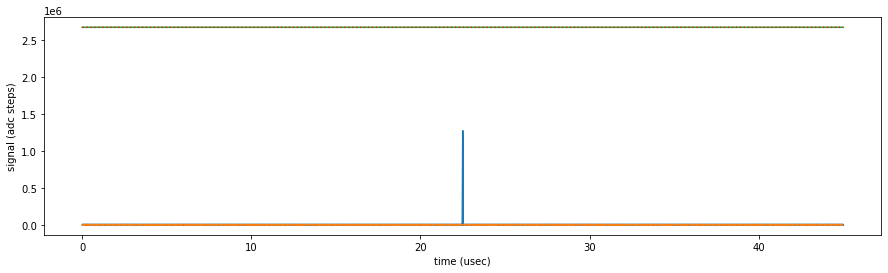

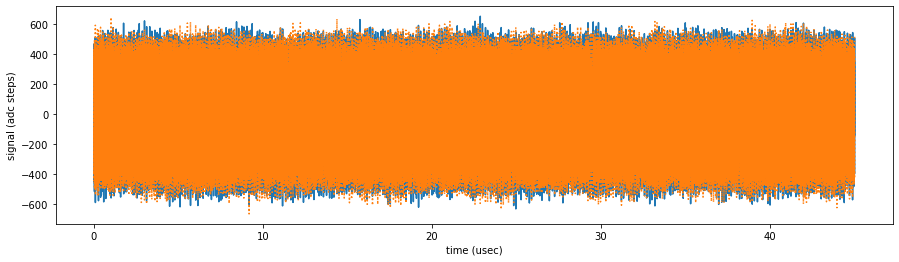

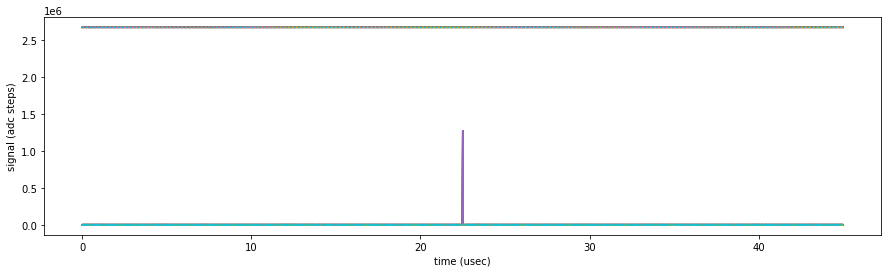

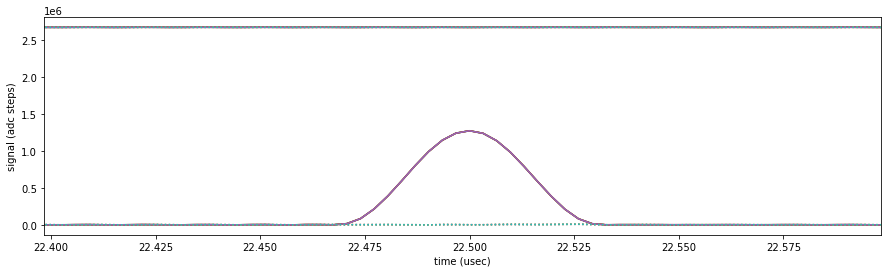

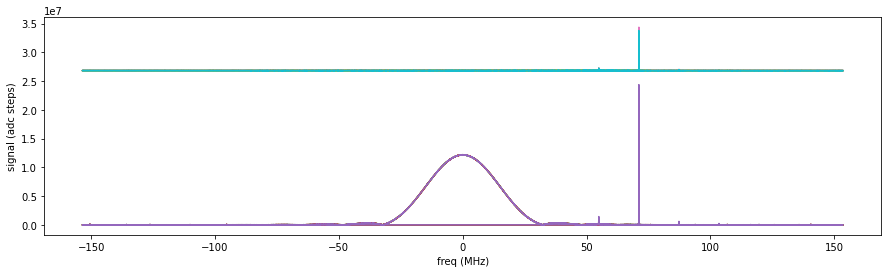

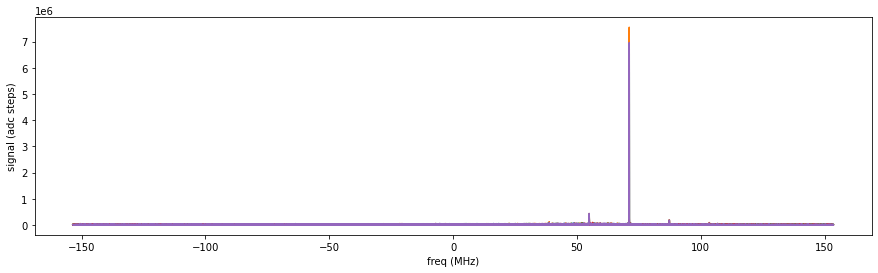

In [4]:
from pynq import PL
PL.reset()

import numpy as np
import matplotlib.pyplot as plt
from pynq import allocate
import xrfdc
import time

from overlay.phase_correction_adjustable_overlay import phase_correction_adjustable_overlay
base = phase_correction_adjustable_overlay('overlay/adj.bit')
base.init_rf_clks()

sampling_rate_in = 4915.2e6 / 8
sampling_rate_after_hilbert = sampling_rate_in/2
# should be a multiple of 512 (64*8)
ifg_samples = int(sampling_rate_after_hilbert/offset_freq*0.95*0.95/512.)*512
# data type is 2*int32 (real+imag)
ifg_values = int(ifg_samples*2)
data_type = np.int32

# allocates two ddr buffers (avg and final result)
avg_mem = allocate(shape=(ifg_values,), dtype=data_type, target=base.ddr.ddr4_0)
print('averager buffer address, something wrong if not >= 0x1000000000: ', hex(avg_mem.physical_address))
avg_mem[:] = np.zeros(ifg_values, dtype=data_type)
avg_mem.flush()
base.radio.pc_averager.write(base.radio.pc_averager.register_map.avg_mem_offset_1.address, int(avg_mem.physical_address & 0x00000000ffffffff))
base.radio.pc_averager.write(base.radio.pc_averager.register_map.avg_mem_offset_2.address, int(avg_mem.physical_address/2**32))

result_mem = allocate(shape=(ifg_values,), dtype=data_type, target=base.ddr.ddr4_0)
print('result address, something wrong if not >= 0x1000000000: ', hex(result_mem.physical_address))
result_mem[:] = np.zeros(ifg_values, dtype=data_type)
result_mem.flush()
base.radio.pc_averager.write(base.radio.pc_averager.register_map.result_mem_offset_1.address, int(result_mem.physical_address & 0x00000000ffffffff))
base.radio.pc_averager.write(base.radio.pc_averager.register_map.result_mem_offset_2.address, int(result_mem.physical_address/2**32))

avg_mem2 = allocate(shape=(ifg_values,), dtype=data_type, target=base.ddr.ddr4_0)
print('averager buffer address, something wrong if not >= 0x1000000000: ', hex(avg_mem2.physical_address))
avg_mem2[:] = np.zeros(ifg_values, dtype=data_type)
avg_mem2.flush()
base.radio.pc_averager_2.write(base.radio.pc_averager_2.register_map.avg_mem_offset_1.address, int(avg_mem2.physical_address & 0x00000000ffffffff))
base.radio.pc_averager_2.write(base.radio.pc_averager_2.register_map.avg_mem_offset_2.address, int(avg_mem2.physical_address/2**32))

result_mem2 = allocate(shape=(ifg_values,), dtype=data_type, target=base.ddr.ddr4_0)
print('result address, something wrong if not >= 0x1000000000: ', hex(result_mem2.physical_address))
result_mem2[:] = np.zeros(ifg_values, dtype=data_type)
result_mem2.flush()
base.radio.pc_averager_2.write(base.radio.pc_averager_2.register_map.result_mem_offset_1.address, int(result_mem2.physical_address & 0x00000000ffffffff))
base.radio.pc_averager_2.write(base.radio.pc_averager_2.register_map.result_mem_offset_2.address, int(result_mem2.physical_address/2**32))

# needs to be large enough for at least one detuning plus the measure worker time (3500 clocks)
# if the measurement starts at a bad moment, the delay until the first ifg also must fit
# therefore, 3*ifg_samples is comfortable
process_buffer_length = 3*ifg_values
data_type = np.int16

buffer_mem = allocate(shape=(process_buffer_length,), dtype=data_type, target=base.ddr.ddr4_0)
print('buffer address, something wrong if not >= 0x1000000000: ', hex(buffer_mem.physical_address))
buffer_mem[:] = np.zeros(process_buffer_length, dtype=data_type)
buffer_mem.flush()
base.radio.dma_passer.write(base.radio.dma_passer.register_map.mem_w_offset_1.address, int(buffer_mem.physical_address & 0x00000000ffffffff))
base.radio.dma_passer.write(base.radio.dma_passer.register_map.mem_w_offset_2.address, int(buffer_mem.physical_address/2**32))
base.radio.dma_passer.write(base.radio.dma_passer.register_map.mem_r_offset_1.address, int(buffer_mem.physical_address & 0x00000000ffffffff))
base.radio.dma_passer.write(base.radio.dma_passer.register_map.mem_r_offset_2.address, int(buffer_mem.physical_address/2**32))
base.radio.dma_passer.write(base.radio.dma_passer.register_map.num_samples.address, process_buffer_length)

buffer_mem2 = allocate(shape=(process_buffer_length,), dtype=data_type, target=base.ddr.ddr4_0)
print('buffer address, something wrong if not >= 0x1000000000: ', hex(buffer_mem2.physical_address))
buffer_mem2[:] = np.zeros(process_buffer_length, dtype=data_type)
buffer_mem2.flush()
base.radio.dma_passer_2.write(base.radio.dma_passer_2.register_map.mem_w_offset_1.address, int(buffer_mem2.physical_address & 0x00000000ffffffff))
base.radio.dma_passer_2.write(base.radio.dma_passer_2.register_map.mem_w_offset_2.address, int(buffer_mem2.physical_address/2**32))
base.radio.dma_passer_2.write(base.radio.dma_passer_2.register_map.mem_r_offset_1.address, int(buffer_mem2.physical_address & 0x00000000ffffffff))
base.radio.dma_passer_2.write(base.radio.dma_passer_2.register_map.mem_r_offset_2.address, int(buffer_mem2.physical_address/2**32))
base.radio.dma_passer_2.write(base.radio.dma_passer_2.register_map.num_samples.address, process_buffer_length)

# configure measure worker and averager to the correct sample length and delay
base.radio.measure_worker.write(base.radio.measure_worker.register_map.num_samples.address, ifg_samples)
base.radio.measure_worker.write(base.radio.measure_worker.register_map.delay_ch_2.address, delay_ch_2)
base.radio.measure_worker.write(base.radio.measure_worker.register_map.phase_mult_ch_2.address, phase_mult_ch_2)
base.radio.trigger_worker.write(base.radio.trigger_worker.register_map.trig_val_sq.address, trig_val**2)

base.radio.pc_averager.write(base.radio.pc_averager.register_map.num_samples.address, ifg_samples)
base.radio.pc_averager_2.write(base.radio.pc_averager_2.register_map.num_samples.address, ifg_samples)

# configures averages
hardware_avgs = 1000
base.radio.pc_averager.write(base.radio.pc_averager.register_map.demanded_avgs.address, hardware_avgs)
base.radio.pc_averager_2.write(base.radio.pc_averager_2.register_map.demanded_avgs.address, hardware_avgs)

# turns on all writer ips (and auto restart) (all must be on to avoid backpressure deadlock)
base.radio.pc_averager.write(base.radio.pc_averager.register_map.CTRL.address, 0x81)
base.radio.writer_log.write(base.radio.writer_log.register_map.CTRL.address, 0x81)
base.radio.writer_orig.write(base.radio.writer_orig.register_map.CTRL.address, 0x81)
base.radio.writer_orig_corrected.write(base.radio.writer_orig_corrected.register_map.CTRL.address, 0x81)
base.radio.pc_averager_2.write(base.radio.pc_averager_2.register_map.CTRL.address, 0x81)
base.radio.writer_orig_2.write(base.radio.writer_orig_2.register_map.CTRL.address, 0x81)
base.radio.writer_orig_corrected_2.write(base.radio.writer_orig_corrected_2.register_map.CTRL.address, 0x81)
base.radio.measure_worker.write(base.radio.measure_worker.register_map.CTRL.address, 0x81)

# array to save the result (only needed for software averaging)
software_averages = 3000
software_averages = 20
data = np.zeros([ifg_values, software_averages])
data2 = np.zeros([ifg_values, software_averages])
# turns on the data stream
base.radio.input_passer_double.write(base.radio.input_passer_double.register_map.send.address, 1)
time_1 = time.time()
for cnt in np.arange(0, software_averages)+1: # writing only starts when sending 1
    # tells averager to write the result
    base.radio.pc_averager.write(base.radio.pc_averager.register_map.write_in.address, int(cnt))
    base.radio.pc_averager_2.write(base.radio.pc_averager_2.register_map.write_in.address, int(cnt))
    while(base.radio.pc_averager.read(base.radio.pc_averager.register_map.write_out.address) < cnt):
        pass
    while(base.radio.pc_averager_2.read(base.radio.pc_averager_2.register_map.write_out.address) < cnt):
        pass
    result_mem.invalidate()
    result_mem2.invalidate()
    data[:, cnt-1] = np.copy(result_mem)
    data2[:, cnt-1] = np.copy(result_mem2)
    time_2 = time.time()
    if np.mod(cnt, 200)==0:
        print(
            'meas no:', base.radio.pc_averager.read(base.radio.pc_averager.register_map.write_out.address),
            'meas time avg:', np.round((time_2-time_1)*1e6), ' us ',
            'meas time single:', np.round((time_2-time_1)*1e6/hardware_avgs), ' us')
    time_1 = time_2
base.radio.input_passer_double.write(base.radio.input_passer_double.register_map.send.address, 0)

del result_mem, result_mem2, avg_mem, avg_mem2, buffer_mem, buffer_mem2

data = data[::2, :] + 1j*data[1::2, :]
data2 = data2[::2, :] + 1j*data2[1::2, :]

np.save('data/cross_r_g_iod/data_ch1_' + str(hardware_avgs)+ '_avgs_x' + str(software_averages), data)
np.save('data/cross_r_g_iod/data_ch2_' + str(hardware_avgs)+ '_avgs_x' + str(software_averages), data2)

time_vec = np.arange(0, ifg_samples)/sampling_rate_after_hilbert
freq = np.fft.fftfreq(data.shape[0], d=time_vec[1]-time_vec[0])

datam = np.mean(data, axis=1)
data2m = np.mean(data2, axis=1)
plt.figure(figsize=(15,4))
plt.plot(time_vec*1e6, np.real(datam))
plt.plot(time_vec*1e6, np.imag(datam), ':')
plt.plot(time_vec*1e6, np.real(data2m)+2.1*np.max(np.abs(datam)))
plt.plot(time_vec*1e6, np.imag(data2m)+2.1*np.max(np.abs(datam)), ':')
#plt.xlim([0, 1])
plt.xlabel('time (usec)')
plt.ylabel('signal (adc steps)')
plt.show()

plt.figure(figsize=(15,4))
plt.plot(time_vec*1e6, np.real(data2m))
plt.plot(time_vec*1e6, np.imag(data2m), ':')
#plt.xlim([0, 1])
plt.xlabel('time (usec)')
plt.ylabel('signal (adc steps)')
plt.show()

plt.figure(figsize=(15,4))
plt.plot(time_vec*1e6, np.real(data[:, 0:5]))
plt.plot(time_vec*1e6, np.imag(data[:, 0:5]), ':')
plt.plot(time_vec*1e6, np.real(data2[:, 0:5])+2.1*np.max(np.abs(data[:, 0:5])))
plt.plot(time_vec*1e6, np.imag(data2[:, 0:5])+2.1*np.max(np.abs(data[:, 0:5])), ':')
#plt.xlim([0, 1])
plt.xlabel('time (usec)')
plt.ylabel('signal (adc steps)')
plt.show()

plt.figure(figsize=(15,4))
plt.plot(time_vec*1e6, np.real(data[:, 0:5]))
plt.plot(time_vec*1e6, np.imag(data[:, 0:5]), ':')
plt.plot(time_vec*1e6, np.real(data2[:, 0:5])+2.1*np.max(np.abs(data[:, 0:5])))
plt.plot(time_vec*1e6, np.imag(data2[:, 0:5])+2.1*np.max(np.abs(data[:, 0:5])), ':')
plt.xlim([np.max(time_vec*1e6)/2-0.1, np.max(time_vec*1e6)/2+0.1])
plt.xlabel('time (usec)')
plt.ylabel('signal (adc steps)')
plt.show()

plt.figure(figsize=(15,4))
data_fft = np.fft.fft(data[:, 0:5], axis=0)
data_fft2 = np.fft.fft(data2[:, 0:5], axis=0)
plt.plot(freq*1e-6, np.abs(data_fft[:, 0:5]))
plt.plot(freq*1e-6, np.abs(data_fft2[:, 0:5])+1.1*np.max(np.abs(data_fft[:, 0:5])))
#plt.xlim([0, 1])
plt.xlabel('freq (MHz)')
plt.ylabel('signal (adc steps)')
plt.show()

plt.figure(figsize=(15,4))
plt.plot(freq*1e-6, np.abs(data_fft2[:, 0:5]))
#plt.xlim([0, 1])
plt.xlabel('freq (MHz)')
plt.ylabel('signal (adc steps)')
plt.show()



In [5]:
from pynq import PL
PL.reset()

import numpy as np
import matplotlib.pyplot as plt
from pynq import allocate
import xrfdc
import time

from overlay.phase_correction_adjustable_overlay import phase_correction_adjustable_overlay
base = phase_correction_adjustable_overlay('overlay/adj.bit')
base.init_rf_clks()

sampling_rate_in = 4915.2e6 / 8
sampling_rate_after_hilbert = sampling_rate_in/2
# should be a multiple of 512 (64*8)
ifg_samples = int(sampling_rate_after_hilbert/offset_freq*0.95*0.95/512.)*512
ifg_values = int(ifg_samples*2)

# should be a multiple of 1024 (64*16)
num_write_samples = int(27*512*10)  # 1000 for pub
# data type is 2*int16 (real+imag)
num_write_values = int(num_write_samples*2)
data_type = np.int16

# allocates a ddr buffer
result_mem = allocate(shape=(num_write_values,), dtype=data_type, target=base.ddr.ddr4_0)
print('address, something wrong if not > 0x1000000000: ', hex(result_mem.physical_address))
result_mem[:] = np.zeros(num_write_values, dtype=data_type)
result_mem.flush()
base.radio.writer_orig_corrected.write(base.radio.writer_orig_corrected.register_map.result_mem_offset_1.address, int(result_mem.physical_address & 0x00000000ffffffff))
base.radio.writer_orig_corrected.write(base.radio.writer_orig_corrected.register_map.result_mem_offset_2.address, int(result_mem.physical_address/2**32))

result_mem2 = allocate(shape=(num_write_values,), dtype=data_type, target=base.ddr.ddr4_0)
print('address, something wrong if not > 0x1000000000: ', hex(result_mem2.physical_address))
result_mem2[:] = np.zeros(num_write_values, dtype=data_type)
result_mem2.flush()
base.radio.writer_orig_corrected_2.write(base.radio.writer_orig_corrected_2.register_map.result_mem_offset_1.address, int(result_mem2.physical_address & 0x00000000ffffffff))
base.radio.writer_orig_corrected_2.write(base.radio.writer_orig_corrected_2.register_map.result_mem_offset_2.address, int(result_mem2.physical_address/2**32))

# needs to be large enough for at least one detuning plus the measure worker time (3500 clocks)
# if the measurement starts at a bad moment, the delay until the first ifg also must fit
# therefore, 3*ifg_samples is comfortable
process_buffer_length = 3*ifg_values
data_type = np.int16

buffer_mem = allocate(shape=(process_buffer_length,), dtype=data_type, target=base.ddr.ddr4_0)
print('buffer address, something wrong if not >= 0x1000000000: ', hex(buffer_mem.physical_address))
buffer_mem[:] = np.zeros(process_buffer_length, dtype=data_type)
buffer_mem.flush()
base.radio.dma_passer.write(base.radio.dma_passer.register_map.mem_w_offset_1.address, int(buffer_mem.physical_address & 0x00000000ffffffff))
base.radio.dma_passer.write(base.radio.dma_passer.register_map.mem_w_offset_2.address, int(buffer_mem.physical_address/2**32))
base.radio.dma_passer.write(base.radio.dma_passer.register_map.mem_r_offset_1.address, int(buffer_mem.physical_address & 0x00000000ffffffff))
base.radio.dma_passer.write(base.radio.dma_passer.register_map.mem_r_offset_2.address, int(buffer_mem.physical_address/2**32))
base.radio.dma_passer.write(base.radio.dma_passer.register_map.num_samples.address, process_buffer_length)

buffer_mem2 = allocate(shape=(process_buffer_length,), dtype=data_type, target=base.ddr.ddr4_0)
print('buffer address, something wrong if not >= 0x1000000000: ', hex(buffer_mem2.physical_address))
buffer_mem2[:] = np.zeros(process_buffer_length, dtype=data_type)
buffer_mem2.flush()
base.radio.dma_passer_2.write(base.radio.dma_passer_2.register_map.mem_w_offset_1.address, int(buffer_mem2.physical_address & 0x00000000ffffffff))
base.radio.dma_passer_2.write(base.radio.dma_passer_2.register_map.mem_w_offset_2.address, int(buffer_mem2.physical_address/2**32))
base.radio.dma_passer_2.write(base.radio.dma_passer_2.register_map.mem_r_offset_1.address, int(buffer_mem2.physical_address & 0x00000000ffffffff))
base.radio.dma_passer_2.write(base.radio.dma_passer_2.register_map.mem_r_offset_2.address, int(buffer_mem2.physical_address/2**32))
base.radio.dma_passer_2.write(base.radio.dma_passer_2.register_map.num_samples.address, process_buffer_length)

# configure measure worker and averager to the correct sample length and delay
base.radio.measure_worker.write(base.radio.measure_worker.register_map.num_samples.address, ifg_samples)
base.radio.measure_worker.write(base.radio.measure_worker.register_map.delay_ch_2.address, delay_ch_2)
base.radio.measure_worker.write(base.radio.measure_worker.register_map.phase_mult_ch_2.address, phase_mult_ch_2)
base.radio.trigger_worker.write(base.radio.trigger_worker.register_map.trig_val_sq.address, trig_val**2)

# configures averages (set demanded_avgs to 0 to avoid memory access but must set num_samples to avoid backpressure)
base.radio.pc_averager.write(base.radio.pc_averager.register_map.num_samples.address, ifg_samples)
base.radio.pc_averager_2.write(base.radio.pc_averager_2.register_map.num_samples.address, ifg_samples)
base.radio.pc_averager.write(base.radio.pc_averager.register_map.demanded_avgs.address, 0)
base.radio.pc_averager_2.write(base.radio.pc_averager_2.register_map.demanded_avgs.address, 0)

# tells writer_orig_corrected to write the result
base.radio.writer_orig_corrected.write(base.radio.writer_orig_corrected.register_map.num_samples.address, int(num_write_samples))
base.radio.writer_orig_corrected.write(base.radio.writer_orig_corrected.register_map.write_in.address, 1)

base.radio.writer_orig_corrected_2.write(base.radio.writer_orig_corrected_2.register_map.num_samples.address, int(num_write_samples))
base.radio.writer_orig_corrected_2.write(base.radio.writer_orig_corrected_2.register_map.write_in.address, 1)

# turns on all writer ips (and auto restart) (all must be on to avoid backpressure deadlock)
base.radio.pc_averager.write(base.radio.pc_averager.register_map.CTRL.address, 0x81)
base.radio.writer_log.write(base.radio.writer_log.register_map.CTRL.address, 0x81)
base.radio.writer_orig.write(base.radio.writer_orig.register_map.CTRL.address, 0x81)
base.radio.writer_orig_corrected.write(base.radio.writer_orig_corrected.register_map.CTRL.address, 0x81)
base.radio.pc_averager_2.write(base.radio.pc_averager_2.register_map.CTRL.address, 0x81)
base.radio.writer_orig_2.write(base.radio.writer_orig_2.register_map.CTRL.address, 0x81)
base.radio.writer_orig_corrected_2.write(base.radio.writer_orig_corrected_2.register_map.CTRL.address, 0x81)
base.radio.measure_worker.write(base.radio.measure_worker.register_map.CTRL.address, 0x81)

# turns on the data stream
print('measuring')
base.radio.input_passer_double.write(base.radio.input_passer_double.register_map.send.address, 1)
while(base.radio.writer_orig_corrected.read(base.radio.writer_orig_corrected.register_map.write_out.address) < 1):
    pass
while(base.radio.writer_orig_corrected_2.read(base.radio.writer_orig_corrected_2.register_map.write_out.address) < 1):
    pass
base.radio.input_passer_double.write(base.radio.input_passer_double.register_map.send.address, 0)
print('finished')

result_mem.invalidate()
result_mem2.invalidate()
data = np.copy(result_mem)
data2 = np.copy(result_mem2)

del result_mem, result_mem2, buffer_mem, buffer_mem2

data = data[::2] + 1j*data[1::2]
data2 = data2[::2] + 1j*data2[1::2]

time_vec = np.arange(0, num_write_samples)/sampling_rate_after_hilbert
freq = np.fft.fftfreq(data.shape[0], d=time_vec[1]-time_vec[0])

if 0:
    plt.figure(figsize=(15,4))
    plt.plot(time_vec*1e6, np.real(data))
    plt.plot(time_vec*1e6, np.imag(data))
    plt.plot(time_vec*1e6, np.real(data2)+2.1*np.max(np.abs(data)))
    plt.plot(time_vec*1e6, np.imag(data2)+2.1*np.max(np.abs(data)))
    #plt.xlim([0, 1])
    plt.xlabel('time (usec)')
    plt.ylabel('signal (adc steps)')
    plt.show()

    plt.figure(figsize=(15,4))
    data_fft = np.fft.fft(data)
    data_fft2 = np.fft.fft(data2)
    plt.plot(freq*1e-6, np.abs(data_fft))
    plt.plot(freq*1e-6, np.abs(data_fft2)+1.1*np.max(np.abs(data_fft)))
    #plt.xlim([0, 1])
    plt.xlabel('freq (MHz)')
    plt.ylabel('signal (adc steps)')
    plt.show()

#np.save('data/cross_g_g/data_ch1_orig_corrected', data)
#np.save('data/cross_g_g/data_ch2_orig_corrected', data2)


address, something wrong if not > 0x1000000000:  0x1000000000
address, something wrong if not > 0x1000000000:  0x1000087000
buffer address, something wrong if not >= 0x1000000000:  0x100010e000
buffer address, something wrong if not >= 0x1000000000:  0x1000137000
measuring
finished


In [6]:
from pynq import PL
PL.reset()

import numpy as np
import matplotlib.pyplot as plt
from pynq import allocate
import xrfdc
import time

from overlay.phase_correction_adjustable_overlay import phase_correction_adjustable_overlay
base = phase_correction_adjustable_overlay('overlay/adj.bit')
base.init_rf_clks()

sampling_rate_in = 4915.2e6 / 8
sampling_rate_after_hilbert = sampling_rate_in/2
# should be a multiple of 512 (64*8)
ifg_samples = int(sampling_rate_after_hilbert/offset_freq*0.95*0.95/512.)*512
ifg_values = int(ifg_samples*2)

# should be a multiple of 1024 (64*16)
num_write_samples = int(27*512*10)  # 1000 for pub
# data type is 2*int16 (real+imag)
num_write_values = int(num_write_samples*2)
data_type = np.int16

# allocates a ddr buffer
result_mem = allocate(shape=(num_write_values,), dtype=data_type, target=base.ddr.ddr4_0)
print('address, something wrong if not > 0x1000000000: ', hex(result_mem.physical_address))
result_mem[:] = np.zeros(num_write_values, dtype=data_type)
result_mem.flush()
base.radio.writer_orig.write(base.radio.writer_orig.register_map.result_mem_offset_1.address, int(result_mem.physical_address & 0x00000000ffffffff))
base.radio.writer_orig.write(base.radio.writer_orig.register_map.result_mem_offset_2.address, int(result_mem.physical_address/2**32))

result_mem2 = allocate(shape=(num_write_values,), dtype=data_type, target=base.ddr.ddr4_0)
print('address, something wrong if not > 0x1000000000: ', hex(result_mem2.physical_address))
result_mem2[:] = np.zeros(num_write_values, dtype=data_type)
result_mem2.flush()
base.radio.writer_orig_2.write(base.radio.writer_orig_2.register_map.result_mem_offset_1.address, int(result_mem2.physical_address & 0x00000000ffffffff))
base.radio.writer_orig_2.write(base.radio.writer_orig_2.register_map.result_mem_offset_2.address, int(result_mem2.physical_address/2**32))

# needs to be large enough for at least one detuning plus the measure worker time (3500 clocks)
# if the measurement starts at a bad moment, the delay until the first ifg also must fit
# therefore, 3*ifg_samples is comfortable
process_buffer_length = 3*ifg_values
data_type = np.int16

buffer_mem = allocate(shape=(process_buffer_length,), dtype=data_type, target=base.ddr.ddr4_0)
print('buffer address, something wrong if not >= 0x1000000000: ', hex(buffer_mem.physical_address))
buffer_mem[:] = np.zeros(process_buffer_length, dtype=data_type)
buffer_mem.flush()
base.radio.dma_passer.write(base.radio.dma_passer.register_map.mem_w_offset_1.address, int(buffer_mem.physical_address & 0x00000000ffffffff))
base.radio.dma_passer.write(base.radio.dma_passer.register_map.mem_w_offset_2.address, int(buffer_mem.physical_address/2**32))
base.radio.dma_passer.write(base.radio.dma_passer.register_map.mem_r_offset_1.address, int(buffer_mem.physical_address & 0x00000000ffffffff))
base.radio.dma_passer.write(base.radio.dma_passer.register_map.mem_r_offset_2.address, int(buffer_mem.physical_address/2**32))
base.radio.dma_passer.write(base.radio.dma_passer.register_map.num_samples.address, process_buffer_length)

buffer_mem2 = allocate(shape=(process_buffer_length,), dtype=data_type, target=base.ddr.ddr4_0)
print('buffer address, something wrong if not >= 0x1000000000: ', hex(buffer_mem2.physical_address))
buffer_mem2[:] = np.zeros(process_buffer_length, dtype=data_type)
buffer_mem2.flush()
base.radio.dma_passer_2.write(base.radio.dma_passer_2.register_map.mem_w_offset_1.address, int(buffer_mem2.physical_address & 0x00000000ffffffff))
base.radio.dma_passer_2.write(base.radio.dma_passer_2.register_map.mem_w_offset_2.address, int(buffer_mem2.physical_address/2**32))
base.radio.dma_passer_2.write(base.radio.dma_passer_2.register_map.mem_r_offset_1.address, int(buffer_mem2.physical_address & 0x00000000ffffffff))
base.radio.dma_passer_2.write(base.radio.dma_passer_2.register_map.mem_r_offset_2.address, int(buffer_mem2.physical_address/2**32))
base.radio.dma_passer_2.write(base.radio.dma_passer_2.register_map.num_samples.address, process_buffer_length)

# configure measure worker and averager to the correct sample length and delay
base.radio.measure_worker.write(base.radio.measure_worker.register_map.num_samples.address, ifg_samples)
base.radio.measure_worker.write(base.radio.measure_worker.register_map.delay_ch_2.address, delay_ch_2)
base.radio.measure_worker.write(base.radio.measure_worker.register_map.phase_mult_ch_2.address, phase_mult_ch_2)
base.radio.trigger_worker.write(base.radio.trigger_worker.register_map.trig_val_sq.address, trig_val**2)

# configures averages (set demanded_avgs to 0 to avoid memory access but must set num_samples to avoid backpressure)
base.radio.pc_averager.write(base.radio.pc_averager.register_map.num_samples.address, ifg_samples)
base.radio.pc_averager_2.write(base.radio.pc_averager_2.register_map.num_samples.address, ifg_samples)
base.radio.pc_averager.write(base.radio.pc_averager.register_map.demanded_avgs.address, 0)
base.radio.pc_averager_2.write(base.radio.pc_averager_2.register_map.demanded_avgs.address, 0)

# tells writer_orig to write the result
base.radio.writer_orig.write(base.radio.writer_orig.register_map.num_samples.address, int(num_write_samples))
base.radio.writer_orig.write(base.radio.writer_orig.register_map.write_in.address, 1)

base.radio.writer_orig_2.write(base.radio.writer_orig_2.register_map.num_samples.address, int(num_write_samples))
base.radio.writer_orig_2.write(base.radio.writer_orig_2.register_map.write_in.address, 1)

# turns on all writer ips (and auto restart) (all must be on to avoid backpressure deadlock)
base.radio.pc_averager.write(base.radio.pc_averager.register_map.CTRL.address, 0x81)
base.radio.writer_log.write(base.radio.writer_log.register_map.CTRL.address, 0x81)
base.radio.writer_orig.write(base.radio.writer_orig.register_map.CTRL.address, 0x81)
base.radio.writer_orig_corrected.write(base.radio.writer_orig_corrected.register_map.CTRL.address, 0x81)
base.radio.pc_averager_2.write(base.radio.pc_averager_2.register_map.CTRL.address, 0x81)
base.radio.writer_orig_2.write(base.radio.writer_orig_2.register_map.CTRL.address, 0x81)
base.radio.writer_orig_corrected_2.write(base.radio.writer_orig_corrected_2.register_map.CTRL.address, 0x81)
base.radio.measure_worker.write(base.radio.measure_worker.register_map.CTRL.address, 0x81)

# turns on the data stream
base.radio.input_passer_double.write(base.radio.input_passer_double.register_map.send.address, 1)
while(base.radio.writer_orig.read(base.radio.writer_orig.register_map.write_out.address) < 1):
    pass
while(base.radio.writer_orig_2.read(base.radio.writer_orig_2.register_map.write_out.address) < 1):
    pass
base.radio.input_passer_double.write(base.radio.input_passer_double.register_map.send.address, 0)

result_mem.invalidate()
result_mem2.invalidate()
data = np.copy(result_mem)
data2 = np.copy(result_mem2)

del result_mem, result_mem2, buffer_mem, buffer_mem2

data = data[::2] + 1j*data[1::2]
data2 = data2[::2] + 1j*data2[1::2]

time_vec = np.arange(0, num_write_samples)/sampling_rate_after_hilbert
freq = np.fft.fftfreq(data.shape[0], d=time_vec[1]-time_vec[0])

if 0:
    plt.figure(figsize=(15,4))
    plt.plot(time_vec*1e6, np.real(data))
    plt.plot(time_vec*1e6, np.imag(data))
    plt.plot(time_vec*1e6, np.real(data2)+2.1*np.max(np.abs(data)))
    plt.plot(time_vec*1e6, np.imag(data2)+2.1*np.max(np.abs(data)))
    #plt.xlim([0, 1])
    plt.xlabel('time (usec)')
    plt.ylabel('signal (adc steps)')
    plt.show()

    plt.figure(figsize=(15,4))
    data_fft = np.fft.fft(data)
    data_fft2 = np.fft.fft(data2)
    plt.plot(freq*1e-6, np.abs(data_fft))
    plt.plot(freq*1e-6, np.abs(data_fft2)+1.1*np.max(np.abs(data_fft)))
    #plt.xlim([0, 1])
    plt.xlabel('freq (MHz)')
    plt.ylabel('signal (adc steps)')
    plt.show()

#np.save('data/cross_g_g/data_ch1_orig', data)
#np.save('data/cross_g_g/data_ch2_orig', data2)

address, something wrong if not > 0x1000000000:  0x1000000000
address, something wrong if not > 0x1000000000:  0x1000087000
buffer address, something wrong if not >= 0x1000000000:  0x100010e000
buffer address, something wrong if not >= 0x1000000000:  0x1000137000


address, something wrong if not > 0x1000000000:  0x1000000000
buffer address, something wrong if not >= 0x1000000000:  0x1000050000
buffer address, something wrong if not >= 0x1000000000:  0x1000079000


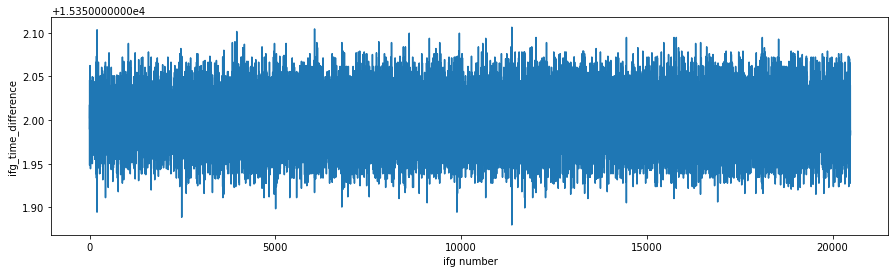

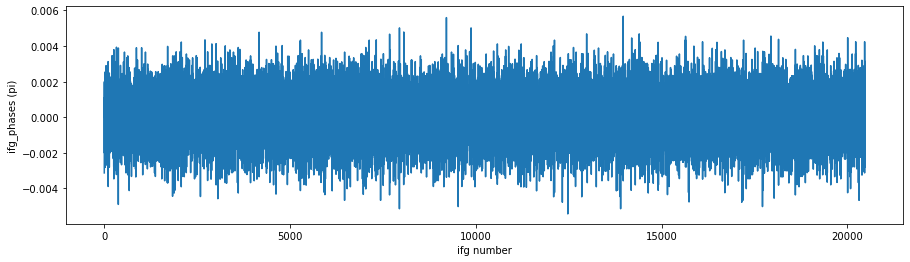

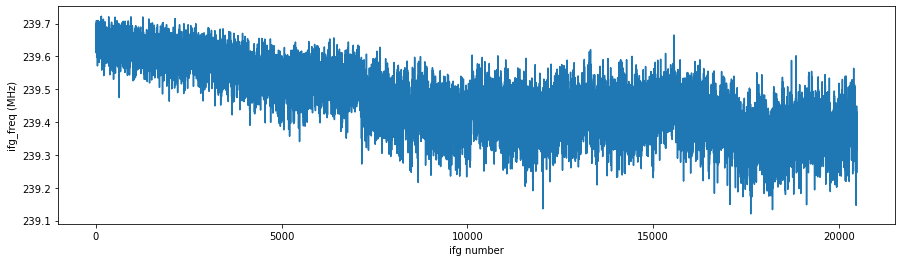

In [7]:
from pynq import PL
PL.reset()

import numpy as np
import matplotlib.pyplot as plt
from pynq import allocate
import xrfdc
import time

from overlay.phase_correction_adjustable_overlay import phase_correction_adjustable_overlay
base = phase_correction_adjustable_overlay('overlay/adj.bit')
base.init_rf_clks()

sampling_rate_in = 4915.2e6 / 8
sampling_rate_after_hilbert = sampling_rate_in/2
# should be a multiple of 512 (64*8)
ifg_samples = int(sampling_rate_after_hilbert/offset_freq*0.95*0.95/512.)*512
ifg_values = int(ifg_samples*2)

# should be a multiple of 1024 (64*16)
num_write_samples = int(1024*20)
# data type is float32*4 (4 different quantities)
num_write_values = int(num_write_samples*4)
data_type = np.float32

# allocates a ddr buffer
result_mem = allocate(shape=(num_write_values,), dtype=data_type, target=base.ddr.ddr4_0)
print('address, something wrong if not > 0x1000000000: ', hex(result_mem.physical_address))
result_mem[:] = np.zeros(num_write_values, dtype=data_type)
result_mem.flush()
base.radio.writer_log.write(base.radio.writer_log.register_map.result_mem_offset_1.address, int(result_mem.physical_address & 0x00000000ffffffff))
base.radio.writer_log.write(base.radio.writer_log.register_map.result_mem_offset_2.address, int(result_mem.physical_address/2**32))

# needs to be large enough for at least one detuning plus the measure worker time (3500 clocks)
# if the measurement starts at a bad moment, the delay until the first ifg also must fit
# therefore, 3*ifg_samples is comfortable
process_buffer_length = 3*ifg_values
data_type = np.int16

buffer_mem = allocate(shape=(process_buffer_length,), dtype=data_type, target=base.ddr.ddr4_0)
print('buffer address, something wrong if not >= 0x1000000000: ', hex(buffer_mem.physical_address))
buffer_mem[:] = np.zeros(process_buffer_length, dtype=data_type)
buffer_mem.flush()
base.radio.dma_passer.write(base.radio.dma_passer.register_map.mem_w_offset_1.address, int(buffer_mem.physical_address & 0x00000000ffffffff))
base.radio.dma_passer.write(base.radio.dma_passer.register_map.mem_w_offset_2.address, int(buffer_mem.physical_address/2**32))
base.radio.dma_passer.write(base.radio.dma_passer.register_map.mem_r_offset_1.address, int(buffer_mem.physical_address & 0x00000000ffffffff))
base.radio.dma_passer.write(base.radio.dma_passer.register_map.mem_r_offset_2.address, int(buffer_mem.physical_address/2**32))
base.radio.dma_passer.write(base.radio.dma_passer.register_map.num_samples.address, process_buffer_length)

buffer_mem2 = allocate(shape=(process_buffer_length,), dtype=data_type, target=base.ddr.ddr4_0)
print('buffer address, something wrong if not >= 0x1000000000: ', hex(buffer_mem2.physical_address))
buffer_mem2[:] = np.zeros(process_buffer_length, dtype=data_type)
buffer_mem2.flush()
base.radio.dma_passer_2.write(base.radio.dma_passer_2.register_map.mem_w_offset_1.address, int(buffer_mem2.physical_address & 0x00000000ffffffff))
base.radio.dma_passer_2.write(base.radio.dma_passer_2.register_map.mem_w_offset_2.address, int(buffer_mem2.physical_address/2**32))
base.radio.dma_passer_2.write(base.radio.dma_passer_2.register_map.mem_r_offset_1.address, int(buffer_mem2.physical_address & 0x00000000ffffffff))
base.radio.dma_passer_2.write(base.radio.dma_passer_2.register_map.mem_r_offset_2.address, int(buffer_mem2.physical_address/2**32))
base.radio.dma_passer_2.write(base.radio.dma_passer_2.register_map.num_samples.address, process_buffer_length)

# configure measure worker and averager to the correct sample length
base.radio.measure_worker.write(base.radio.measure_worker.register_map.num_samples.address, ifg_samples)
base.radio.measure_worker.write(base.radio.measure_worker.register_map.delay_ch_2.address, delay_ch_2)
base.radio.measure_worker.write(base.radio.measure_worker.register_map.phase_mult_ch_2.address, phase_mult_ch_2)
base.radio.trigger_worker.write(base.radio.trigger_worker.register_map.trig_val_sq.address, trig_val**2)

# configures averages (set to 0 to avoid memory access)
base.radio.pc_averager.write(base.radio.pc_averager.register_map.num_samples.address, ifg_samples)
base.radio.pc_averager_2.write(base.radio.pc_averager_2.register_map.num_samples.address, ifg_samples)
base.radio.pc_averager.write(base.radio.pc_averager.register_map.demanded_avgs.address, 0)
base.radio.pc_averager_2.write(base.radio.pc_averager_2.register_map.demanded_avgs.address, 0)

# set up num_samples (all must be set to at least 16 to avoid backpressure deadlock)
# re-uses the other writer, which sends 16 samples at once; log also sends 16 samples per write
# tells writer_log to write the result
base.radio.writer_log.write(base.radio.writer_log.register_map.num_samples.address, num_write_values)
base.radio.writer_log.write(base.radio.writer_log.register_map.write_in.address, 1)

# turns on all writer ips (and auto restart) (all must be on to avoid backpressure deadlock)
base.radio.pc_averager.write(base.radio.pc_averager.register_map.CTRL.address, 0x81)
base.radio.writer_log.write(base.radio.writer_log.register_map.CTRL.address, 0x81)
base.radio.writer_orig.write(base.radio.writer_orig.register_map.CTRL.address, 0x81)
base.radio.writer_orig_corrected.write(base.radio.writer_orig_corrected.register_map.CTRL.address, 0x81)
base.radio.pc_averager_2.write(base.radio.pc_averager_2.register_map.CTRL.address, 0x81)
base.radio.writer_orig_2.write(base.radio.writer_orig_2.register_map.CTRL.address, 0x81)
base.radio.writer_orig_corrected_2.write(base.radio.writer_orig_corrected_2.register_map.CTRL.address, 0x81)
base.radio.measure_worker.write(base.radio.measure_worker.register_map.CTRL.address, 0x81)

# turns on the data stream
base.radio.input_passer_double.write(base.radio.input_passer_double.register_map.send.address, 1)
while(base.radio.writer_log.read(base.radio.writer_log.register_map.write_out.address) < 1):
    pass
base.radio.input_passer_double.write(base.radio.input_passer_double.register_map.send.address, 0)

result_mem.invalidate()
data = np.copy(result_mem)

del result_mem, buffer_mem, buffer_mem2

delta_times = data[::4]
phases = data[1::4]
center_freqs = data[2::4]
spacers = data[3::4]

plt.figure(figsize=(15,4))
plt.plot(delta_times)
#plt.xlim([-10, 1000])
plt.xlabel('ifg number')
plt.ylabel('ifg_time_difference')
plt.show()

plt.figure(figsize=(15,4))
plt.plot(np.diff(np.unwrap(phases*np.pi))/np.pi)
#plt.xlim([-10, 1000])
plt.xlabel('ifg number')
plt.ylabel('ifg_phases (pi)')
plt.show()

plt.figure(figsize=(15,4))
plt.plot((center_freqs*sampling_rate_after_hilbert+sampling_rate_after_hilbert/2)/1e6)
#plt.xlim([-10, 1000])
plt.xlabel('ifg number')
plt.ylabel('ifg_freq (MHz)')
plt.show()